In [1]:
import warnings
warnings.filterwarnings('ignore')

#General Data/Plotting
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from tqdm.auto import tqdm 
import random

# Language
import nltk 
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
import re 
from collections import Counter
from string import punctuation

# Modeling
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split 
from sklearn.metrics import precision_score, recall_score , f1_score, accuracy_score,confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential 
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.layers import Dense , Embedding , Bidirectional , LSTM

lemma = WordNetLemmatizer()

In [2]:
df = pd.read_json('../Datasets/Cell_Phones_and_Accessories_5.json', lines=True)

In [3]:
# rename columns for better understanding
df = df.rename(columns={"reviewText":"Review","overall": "Rating","summary":"Title"})

# drop unessesary data
df.drop(['reviewerID', 'asin', 'reviewerName', 'unixReviewTime', 'reviewTime'], axis='columns', inplace=True)

# split the helpful tuple into two new rows
df['helpful_0'] = df['helpful'].apply(func=lambda x: x[0])
df['helpful_1'] = df['helpful'].apply(func=lambda x: x[1])

# Remove Reviews that have less than 2 helpful votes
df = df[df['helpful_1'] >= 2]

# add calculation of helpfullness ration and convert it to an int percentage
df['helpful_ratio'] = df['helpful_0'] / df['helpful_1']
df['ratio_percent'] = (df['helpful_ratio'] * 100).astype(int)

# calculate length of reviews in new column
df['review_len'] = [len(text.split()) for text in df.Review]

In [4]:
def convert_label(df) : 
    if df['ratio_percent'] <= 70 : 
        rate = 0 # for Negative 
    else : 
        rate = 1 # for Positive
        
    return rate

In [5]:
df['IsHelpful'] = df.apply(convert_label, axis = 1)
df.head()

,helpful,Review,Rating,Title,helpful_0,helpful_1,helpful_ratio,ratio_percent,review_len,IsHelpful
3,"[4, 4]",Item arrived in great time and was in perfect ...,4,Cute!,4,4,1.000000,100,51,1
4,"[2, 3]","awesome! stays on, and looks great. can be use...",5,leopard home button sticker for iphone 4s,2,3,0.666667,66,23,0
5,"[1, 2]",These make using the home button easy. My daug...,3,Cute,1,2,0.500000,50,23,0
7,"[1, 2]",it worked for the first week then it only char...,1,not a good Idea,1,2,0.500000,50,20,0
8,"[2, 3]","Good case, solid build. Protects phone all aro...",5,Solid Case,2,3,0.666667,66,44,0


In [6]:
df['ExclamationMarks_Count'] = df['Review'].str.count('!')
df['QuestionMarks_Count'] = df['Review'].str.count('\?')

In [7]:
# Calculate Ratio/Percent of Punc. Marks relative to review length
df['ExclamationMarks_Ratio'] = df['ExclamationMarks_Count'] / df['review_len']
df['QuestionMarks_Ratio'] = df['QuestionMarks_Count'] / df['review_len']



df['ExclamationMarks_Ratio'] = df['ExclamationMarks_Ratio'].fillna(0)
df['QuestionMarks_Ratio'] = df['QuestionMarks_Ratio'].fillna(0)

df['ExclamationMarks_Percent'] = (df['ExclamationMarks_Ratio'] * 100).astype(int)
df['QuestionMarks_Percent'] = (df['QuestionMarks_Ratio'] * 100).astype(int)
df.head()

,helpful,Review,Rating,Title,helpful_0,helpful_1,helpful_ratio,ratio_percent,review_len,IsHelpful,ExclamationMarks_Count,QuestionMarks_Count,ExclamationMarks_Ratio,QuestionMarks_Ratio,ExclamationMarks_Percent,QuestionMarks_Percent
3,"[4, 4]",Item arrived in great time and was in perfect ...,4,Cute!,4,4,1.000000,100,51,1,0,0,0.000000,0.0,0,0
4,"[2, 3]","awesome! stays on, and looks great. can be use...",5,leopard home button sticker for iphone 4s,2,3,0.666667,66,23,0,1,0,0.043478,0.0,4,0
5,"[1, 2]",These make using the home button easy. My daug...,3,Cute,1,2,0.500000,50,23,0,0,0,0.000000,0.0,0,0
7,"[1, 2]",it worked for the first week then it only char...,1,not a good Idea,1,2,0.500000,50,20,0,0,0,0.000000,0.0,0,0
8,"[2, 3]","Good case, solid build. Protects phone all aro...",5,Solid Case,2,3,0.666667,66,44,0,0,0,0.000000,0.0,0,0


### Preprocessing

In [8]:
def DataPrep(text) : 
    text = re.sub(r'\d+', '', text) # numbers
    text = re.sub(r'[^\w\s]', '', text) # special characters
    
    # tokenization 
    tokens = nltk.word_tokenize(text) 
    
    # remove puncs 
    punc = list(punctuation)
    words = [word for word in tokens if word not in punc]
    
    # remove stopwords 
    stop_words = set(stopwords.words('english'))
    words = [word.lower() for word in words if not word in stop_words]
    
    # lemmatization 
    words = [lemma.lemmatize(word) for word in words]
    
    text = ' '.join(words)
    
    return text

In [9]:
df['cleaned_reviews'] = df['Review'].apply(DataPrep)

In [10]:
df.head()

,helpful,Review,Rating,Title,helpful_0,helpful_1,helpful_ratio,ratio_percent,review_len,IsHelpful,ExclamationMarks_Count,QuestionMarks_Count,ExclamationMarks_Ratio,QuestionMarks_Ratio,ExclamationMarks_Percent,QuestionMarks_Percent,cleaned_reviews
3,"[4, 4]",Item arrived in great time and was in perfect ...,4,Cute!,4,4,1.000000,100,51,1,0,0,0.000000,0.0,0,0,item arrived great time perfect condition howe...
4,"[2, 3]","awesome! stays on, and looks great. can be use...",5,leopard home button sticker for iphone 4s,2,3,0.666667,66,23,0,1,0,0.043478,0.0,4,0,awesome stay look great used multiple apple pr...
5,"[1, 2]",These make using the home button easy. My daug...,3,Cute,1,2,0.500000,50,23,0,0,0,0.000000,0.0,0,0,these make using home button easy my daughter ...
7,"[1, 2]",it worked for the first week then it only char...,1,not a good Idea,1,2,0.500000,50,20,0,0,0,0.000000,0.0,0,0,worked first week charge phone waste money
8,"[2, 3]","Good case, solid build. Protects phone all aro...",5,Solid Case,2,3,0.666667,66,44,0,0,0,0.000000,0.0,0,0,good case solid build protects phone around go...


In [11]:
print(f'There are around {int(df["cleaned_reviews"].duplicated().sum())} duplicated reviews, we will remove them.')

There are around 90 duplicated reviews, we will remove them.


In [12]:
df.drop_duplicates("cleaned_reviews", inplace=True)

### Split Data

In [26]:
x_train, x_val, y_train, y_val, excl_train, excl_val = train_test_split(df['cleaned_reviews'], df['IsHelpful'], df['ExclamationMarks_Percent'], train_size=0.80, random_state=42)

In [27]:
len(x_train), len(x_val)

(22428, 5608)

### Feature Extraction

In [28]:
vec = TfidfVectorizer()
vec.fit(x_train)
print("No. of feature words: ",len(vec.get_feature_names_out()))

No. of feature words:  78975


In [29]:
x_train = vec.transform(x_train).toarray()
x_val = vec.transform(x_val).toarray()

In [30]:
x_train.shape , x_val.shape

((22428, 78975), (5608, 78975))

##### Add 'exclamation mark' feature to the TF-IDF transformed data

In [31]:
# Add 'exclamation mark' feature to the TF-IDF transformed data
x_train_combined = np.column_stack((x_train, excl_train))
x_val_combined = np.column_stack((x_val, excl_val))

In [32]:
print(x_train_combined)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 5.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [33]:
x_train_combined.shape, x_val_combined.shape

((22428, 78976), (5608, 78976))

### Logistic Regression

#### Review+IsHelpful+ExclamationMarks_Percent

In [34]:
lr1 = LogisticRegression(random_state=42)
lr1.fit(x_train_combined, y_train)

LogisticRegression(random_state=42)

In [35]:
train_acc1_2 = lr1.score(x_train_combined , y_train)

In [36]:
lr1_pred = lr1.predict(x_val_combined)

val_acc1_2 = accuracy_score(y_val , lr1_pred) 

val_precision1_2 = precision_score(y_val , lr1_pred , average='weighted')
val_recall1_2 = recall_score(y_val , lr1_pred , average='weighted')
val_f1score1_2 = f1_score(y_val , lr1_pred , average='weighted')

In [37]:
print(f"The training accuracy for logistic regression : {(train_acc1_2*100):0.2f}%\n")
print(f"The validation accuracy for logistic regression : {(val_acc1_2*100):0.2f}%\n")
print(f"The precision for logistic regression : {val_precision1_2:0.2f}\n")
print(f"The recall for logistic regression : {val_recall1_2:0.2f}\n")
print(f"The f1 score for logistic regression : {val_f1score1_2:0.2f}\n")

The training accuracy for logistic regression : 75.00%

The validation accuracy for logistic regression : 62.43%

The precision for logistic regression : 0.62

The recall for logistic regression : 0.62

The f1 score for logistic regression : 0.61



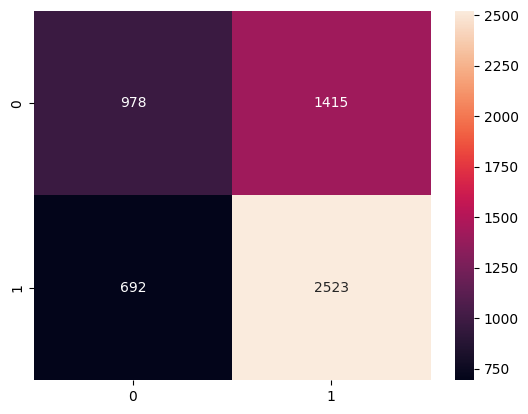

In [38]:
lr1_cm = confusion_matrix(y_val , lr1_pred)
sns.heatmap(lr1_cm, annot=True,fmt='3g')
plt.show()

### Logistic Regression

#### Review+IsHelpful+QuestionMarks_Percent

##### Split Data

In [41]:
x_train, x_val, y_train, y_val, quest_train, quest_val = train_test_split(df['cleaned_reviews'], df['IsHelpful'], df['QuestionMarks_Percent'], train_size=0.80, random_state=42)

In [42]:
len(x_train), len(x_val)

(22428, 5608)

##### Feature Extraction

In [43]:
vec = TfidfVectorizer()
vec.fit(x_train)
print("No. of feature words: ",len(vec.get_feature_names_out()))

No. of feature words:  78975


In [44]:
x_train = vec.transform(x_train).toarray()
x_val = vec.transform(x_val).toarray()

In [46]:
# Add 'equestion mark' feature to the TF-IDF transformed data
x1_train_combined = np.column_stack((x_train, quest_train))
x1_val_combined = np.column_stack((x_val, quest_val))

In [47]:
x1_train_combined.shape, x1_val_combined.shape

((22428, 78976), (5608, 78976))

In [48]:
# Model mit QuestionMark
lr2 = LogisticRegression(random_state=42)
lr2.fit(x1_train_combined, y_train)

LogisticRegression(random_state=42)

In [49]:
train_acc1_3 = lr1.score(x1_train_combined , y_train)

In [50]:
lr2_pred = lr2.predict(x1_val_combined)

val_acc1_3 = accuracy_score(y_val , lr2_pred) 

val_precision1_3 = precision_score(y_val , lr2_pred , average='weighted')
val_recall1_3 = recall_score(y_val , lr2_pred , average='weighted')
val_f1score1_3 = f1_score(y_val , lr2_pred , average='weighted')

In [51]:
print(f"The training accuracy for logistic regression : {(train_acc1_3*100):0.2f}%\n")
print(f"The validation accuracy for logistic regression : {(val_acc1_3*100):0.2f}%\n")
print(f"The precision for logistic regression : {val_precision1_3:0.2f}\n")
print(f"The recall for logistic regression : {val_recall1_3:0.2f}\n")
print(f"The f1 score for logistic regression : {val_f1score1_3:0.2f}\n")

The training accuracy for logistic regression : 74.96%

The validation accuracy for logistic regression : 62.29%

The precision for logistic regression : 0.62

The recall for logistic regression : 0.62

The f1 score for logistic regression : 0.61



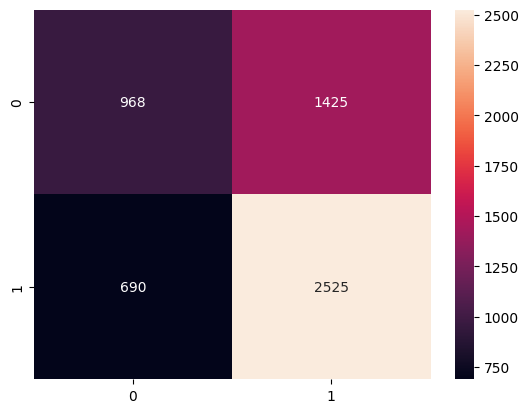

In [52]:
lr2_cm = confusion_matrix(y_val , lr2_pred)
sns.heatmap(lr2_cm, annot=True,fmt='3g')
plt.show()

### Random Forest

#### mit Review+IsHelpful+Len

In [53]:
x_train, x_val, y_train, y_val, len_train, len_val = train_test_split(df['cleaned_reviews'], df['IsHelpful'], df['review_len'], train_size=0.80, random_state=42)

In [54]:
len(x_train), len(x_val)

(22428, 5608)

In [55]:
vec = TfidfVectorizer()
vec.fit(x_train)
print("No. of feature words: ",len(vec.get_feature_names_out()))

No. of feature words:  78975


In [56]:
x_train = vec.transform(x_train).toarray()
x_val = vec.transform(x_val).toarray()

In [57]:
x_train.shape , x_val.shape

((22428, 78975), (5608, 78975))

In [58]:
# Add 'len' feature to the TF-IDF transformed data
x_train_combined = np.column_stack((x_train, len_train))
x_val_combined = np.column_stack((x_val, len_val))

In [59]:
x_train_combined.shape, x_val_combined.shape

((22428, 78976), (5608, 78976))

In [60]:
rf = RandomForestClassifier()
rf.fit(x_train_combined , y_train)

RandomForestClassifier()

In [71]:
train_acc2 = rf.score(x_train_combined , y_train)

In [82]:
rf_pred = rf.predict(x_val_combined)

val_acc2 = accuracy_score(y_val , rf_pred) 

val_precision2 = precision_score(y_val , rf_pred , average='weighted')
val_recall2 = recall_score(y_val , rf_pred , average='weighted')
val_f1score2 = f1_score(y_val , rf_pred , average='weighted')

In [83]:
print(f"The training accuracy for Random Forest : {(train_acc2*100):0.2f}%\n")
print(f"The validation accuracy for Random Forest : {(val_acc2*100):0.2f}%\n")
print(f"The precision for Random Forest : {val_precision2:0.2f}\n")
print(f"The recall for Random Forest : {val_recall2:0.2f}\n")
print(f"The f1 score for Random Forest : {val_f1score2:0.2f}\n")

The training accuracy for Random Forest : 100.00%

The validation accuracy for Random Forest : 60.81%

The precision for Random Forest : 0.60

The recall for Random Forest : 0.61

The f1 score for Random Forest : 0.57

